# If there's no asparagus in Skolkovo...

Hi! This tutorial will lead you to creation of small **recommender system**. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have good asparagus Skolkovo?

Unfortunately some code was "lost", so your task is to restore missing blocks. Let's go!

**NB**. Before you start. Of course, in `numpy` there exist implementations of QR decomposition, QR algorithm, determinant search, SVD and so on. Please, try to avoid shortcuts. One of the important things researched must be able to do is to **implement other's papers**. In this tutorial you will be addressed to papers, describing the ideas with mathematical symbols and pseudocode. Your major task is to show that **you can convert these papers into working code.**

In [1]:
# all necessary import are already here. Just run this box in the very beginning

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Reading dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/ml/nutrition.csv

If you have any questions about what's happening here - please raise your hand.

In [2]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/ml/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
dimensions = dataset.columns[1:]

print("Names:", *names[:5], "...", sep=" | ")
print()
print("Classes:", *set(classes_list), sep=" | ")
print()
print("Dimensions:", *dimensions[:5], "...", sep=" | ")

dataset.head()

Names: | Asparagus, 5 spears (93 g/3.3 oz) | Bell Pepper, 1 medium (148 g/5.3 oz) | Broccoli, 1 medium stalk (148 g/5.3 oz) | Carrot, 1 carrot, 7" long, 1 1/4" diameter (78 g/2.8 oz) | Cauliflower, 1/6 medium head (99 g/3.5 oz) | ...

Classes: | Fruits Serving Size (gram weight/ounce weight) | Vegetables, Serving Size (gram weight/ ounce weight) | Seafood, Serving Size (84 g/3 oz)

Dimensions: | Calories | Calories from Fat | Total Fat 1 | Total Fat 2 | Sodium 1 | ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## Assigning colors each food item
In the end you got the list `color_list` which attribute color to each item.

In [3]:
classes = list(set(classes_list)) # take unique values. After applying 'set', values are not repeated
classes

['Fruits Serving Size (gram weight/ounce weight)',
 'Vegetables, Serving Size (gram weight/ ounce weight)',
 'Seafood, Serving Size (84 g/3 oz)']

In [4]:
classes = list(set(classes_list))# take unique values. After applying 'set', values are not repeated
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
# print(class_colors)
color_list = [class_colors[a] for a in classes_list]
class_colors

{'Fruits Serving Size (gram weight/ounce weight)': 'red',
 'Vegetables, Serving Size (gram weight/ ounce weight)': 'green',
 'Seafood, Serving Size (84 g/3 oz)': 'blue'}

## Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [5]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X.A1, Y.A1, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
    
def show_points_3d(X, Y, Z):
    global color_list
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## The matrix
Now we are ready to start working with matrices. `A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 fearures). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw matrix values, columns are objects (61, 22)


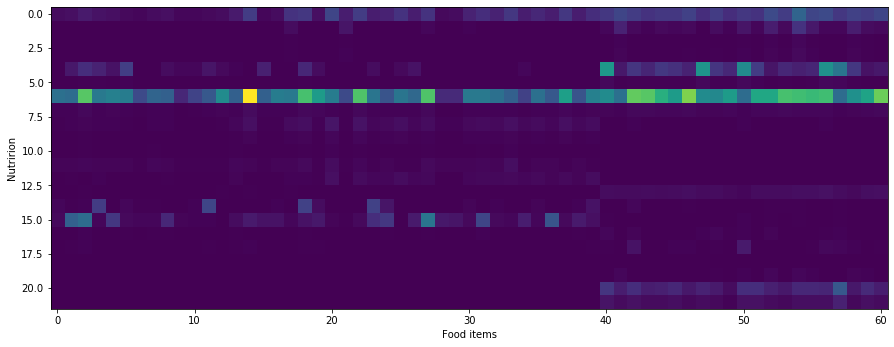

2 random dimensions distribution


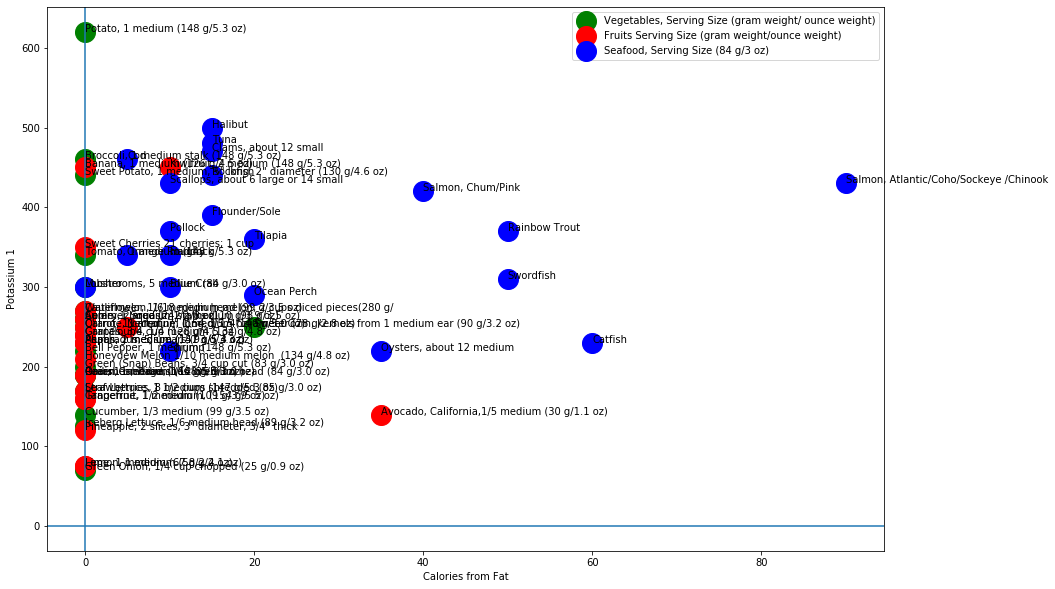

In [6]:
A = np.matrix(dataset.values[1:,1:-1].astype(float))
print("Raw matrix values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutririon")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## Centering the data

**Here comes you first warm-up task!** SVD works only with centered data (linear operators usually have issues with moving points, they can only sqeeze and rotate). We've lost the code that for each dataset feature (for each matrix `A` column) subtracts column-wise mean values. **Please restore this code.**

In [7]:
print("initial matrix\n", A)

initial matrix
 [[ 20.    0.    0.  ...   0.    0.    0. ]
 [ 25.    0.    0.  ...   0.    0.    0. ]
 [ 45.    0.    0.5 ...   0.    0.    0. ]
 ...
 [120.   50.    6.  ...   8.   40.   13. ]
 [110.   20.    2.5 ...   5.   75.   25. ]
 [130.   15.    1.5 ...   0.   50.   17. ]]


2 random dimensions distribution centered


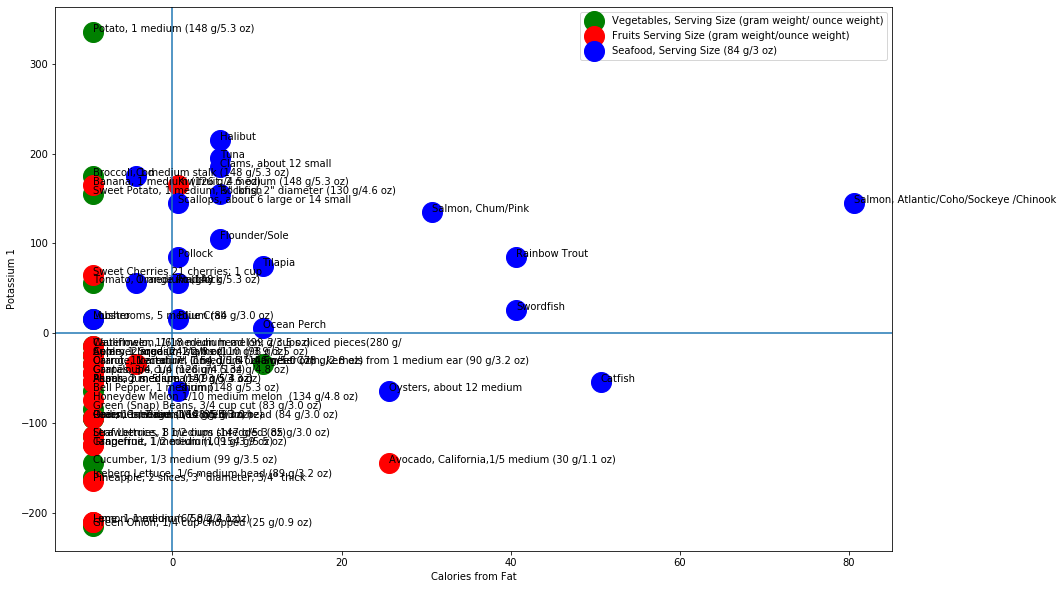

In [8]:
#I should normalize my data by each coloumn
def centered(A):
    C = A.copy()

    C = C - np.mean(C, axis=0)
    
    return C

Ac = centered(A)

#checking my solution
assert np.allclose(np.mean(Ac, axis=0), np.zeros((22, 1))), "After centering, average value of the column should be equal to 0"

print("2 random dimensions distribution centered")
show_points_2d(Ac.T[1], Ac.T[6], dimensions[1], dimensions[6])

## Why do we need these matrices

According to [Wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition) SVD builds up 3 matrices $U$, $\Sigma$, $V^T$. 

$U$ is a collection of eigenvectors of $AA^T$. 

$V^T$ is a collection of eigenvectors of $A^TA$. 

$\Sigma$ holds square roots of positive eigenvalues (they are similar for both matrices). Matrices will appear again later.

In [79]:
ATA = Ac.T * Ac
AAT = Ac * Ac.T

## QR decomposition

**Here comes first non-trivial problem!** Let me remind, that to find eigenvalues of a matrix, we use QR algorithm. QR algorithm uses QR decomposition in its core. 
QR decomposition we considered at the lecture is known as *Gram-Schmidt* process and is well-described in [this paper](https://www.math.ucla.edu/~yanovsky/Teaching/Math151B/handouts/GramSchmidt.pdf) and in [Wikipedia article](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process). Please implement this method and pass the test.

In [78]:
# maybe you will need this, feel free to reuse
def proj(u, a):
     return u * np.dot(np.ravel(u), np.ravel(a)) 


def QR(A):
    Q = A.copy()
    R = np.zeros(A.shape)

    for icol in range(Q.shape[1]):  
        
        for j in range(icol + 1):
            if j == 0:
                Q[:, icol] = A[:, icol] #ui = ai
            else:
                p = proj(Q[:, j - 1], A[:, icol]) #project_u_j-1{a_icol}
                Q[:, icol] = Q[:, icol] - p  #

            if icol == j: # add elem at the end of the loop
                e = Q[:, icol] / np.linalg.norm(Q[:, icol])
                Q[:, icol] = e
            R[j, icol] = np.dot(np.ravel(Q[:, j]), np.ravel(A[:, icol]))
            
    
    # your algoritm can return Q = -Q, thus use this "cheat" with "np.linalg.det(Q)" to fix sign. Sorry for this :)
    if np.linalg.det(Q) < 0:
        Q, R = -Q, -R
    return Q, R


def detQR(A):
    Q, R = QR(A)
    return np.prod(np.diag(R))
    

# test from the paper
M = np.matrix([[1.0, 1.0, 0.0], 
               [1.0, 0.0, 1.0], 
               [0.0, 1.0, 1.0]])

Q, R = QR(M)
print("Decomposition works:", np.allclose(M, Q * R)) # multiplication of Q and R shoud give initial matrix M
print("Determinant feature works:", np.allclose(detQR(M), np.linalg.det(M)))
print(Q)
print(R)

Decomposition works: True
Determinant feature works: True
[[-0.70710678 -0.40824829  0.57735027]
 [-0.70710678  0.40824829 -0.57735027]
 [-0.         -0.81649658 -0.57735027]]
[[-1.41421356 -0.70710678 -0.70710678]
 [-0.         -1.22474487 -0.40824829]
 [-0.         -0.         -1.15470054]]


In [76]:
np.linalg.qr(M)

(matrix([[-0.70710678,  0.40824829, -0.57735027],
         [-0.70710678, -0.40824829,  0.57735027],
         [-0.        ,  0.81649658,  0.57735027]]),
 matrix([[-1.41421356, -0.70710678, -0.70710678],
         [ 0.        ,  1.22474487,  0.40824829],
         [ 0.        ,  0.        ,  1.15470054]]))

## QR algorithm
Oh no! This happened again. We've lost some code :( You need to restore basic QR algorithm from this [book chapter, page 64](http://people.inf.ethz.ch/arbenz/ewp/Lnotes/chapter4.pdf). **Please, write the code that returns 2 matrices produced by the algorithm: first holds eigenvalues on the diagonal, second holds eigenvectors.**

Ok. this algorithms will not solve the problem exactly - it has issues with stability, that is why `eigenvalues[0, 0] * eigenvectors[:, 0] != ATA * eigenvectors[:, 0]`. But anyway, it should return relatively small numbers.

In [82]:
ATA.shape

(22, 22)

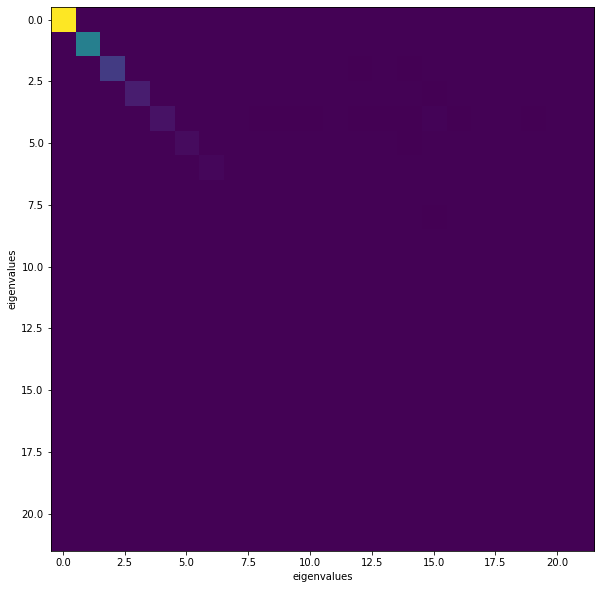

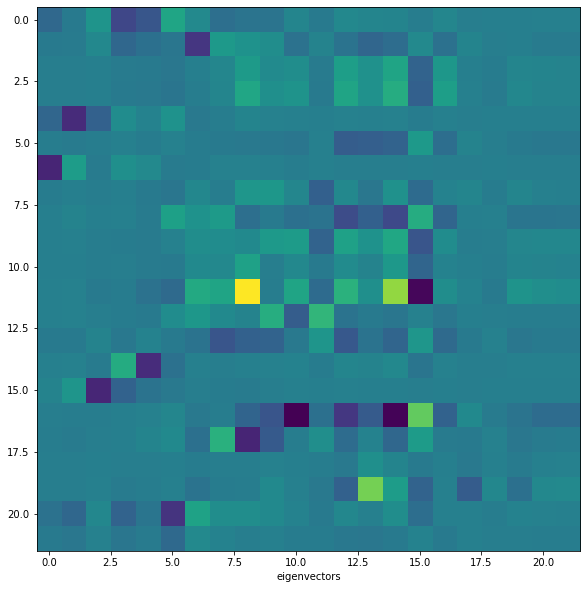

In [130]:
def QR_algorithm(X, iters=10):
    A = X.copy()
    U = np.eye(X.shape[0], X.shape[1])
    
    A_prev = A # Ak-1
    
    for i in range(iters):
        Q, R = QR(A)
#         A_prev = np.matmul(Q, R)
        A = np.matmul(R, Q)
        U = np.matmul(U, Q)
    return A, U

eigenvalues, eigenvectors = QR_algorithm(ATA)
assert np.prod(abs(eigenvalues[0, 0] * eigenvectors[:, 0] - ATA * eigenvectors[:, 0]) < 1000) == 1, "This was pretty simple eigenvalues test. And you failed even the test :("

show_matrix(eigenvalues, "eigenvalues", "eigenvalues")
show_matrix(eigenvectors, "eigenvectors", "")

## And here comes [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)

You are close to the result. The only remaining thing left: Matrix $\Sigma$, which is exactly of the size of decomposed matrix, holds square roots of *positive* eigenvalues (zeros otherwise). **Please, restore the code that builds the matrix $\Sigma$.**

In [131]:
def SVD(A):
    AAT = A * A.T
    ATA = A.T * A
    s2, U = QR_algorithm(AAT) #take matrix with more dimension
    _, VT = QR_algorithm(ATA)
    S = np.zeros((U.shape[0], VT.shape[1]))
    np.fill_diagonal(S, s2)
    

    
    return U, S, VT

U, S, VT = SVD(Ac)


## Principal components
Principal components are the dimensions, which express the difference in the dataset in the best way. The variance is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's visualize 2 and 3 principal components.

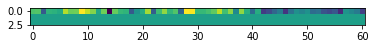

2 first dimensions


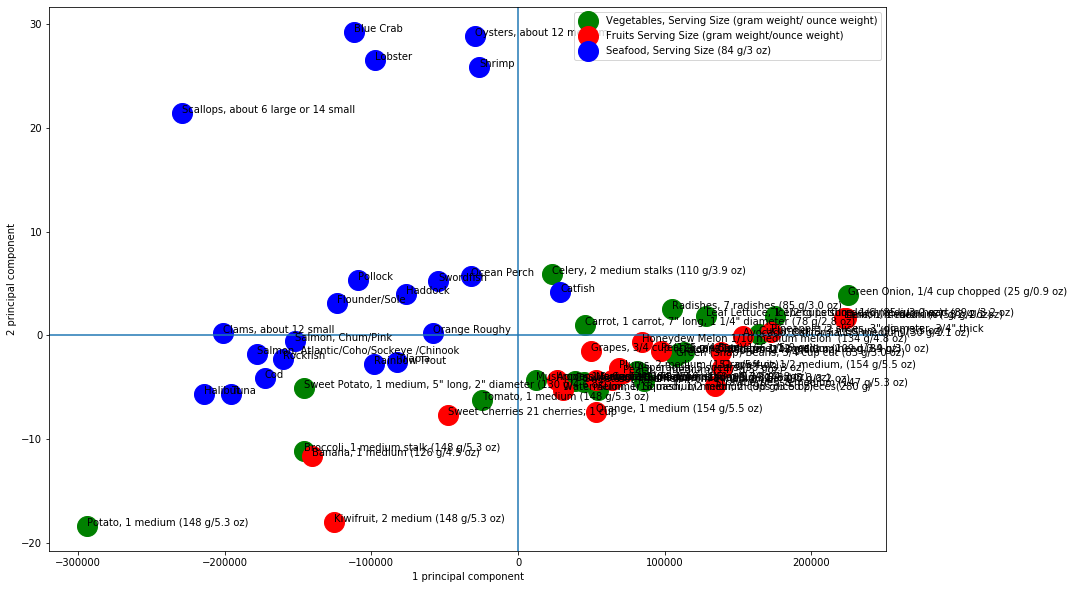

3 first dimensions


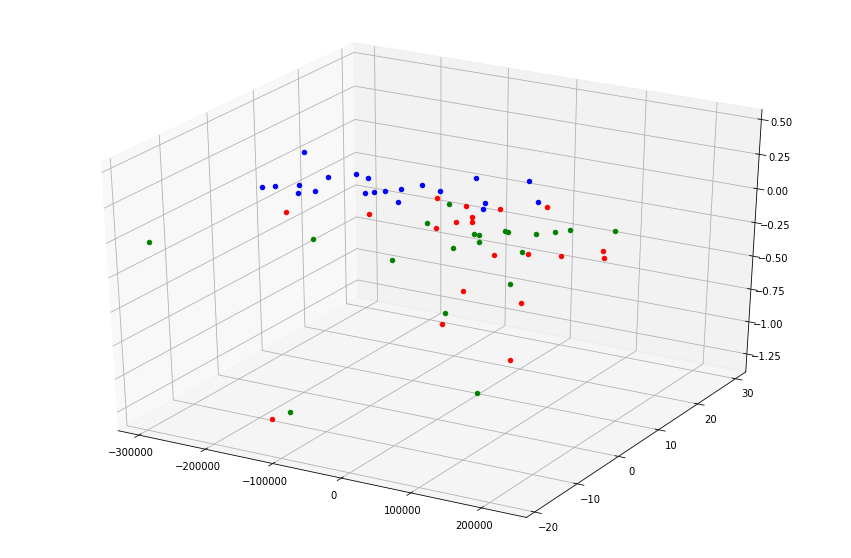

In [132]:
k = 3

# this matrix has a size (items)x(k) and represent our food items in less-dimensional (k-dimensional) space
# in this new space the smaller the column index, the more valuable the component
Ak = U[:, :k] * S[:k, :k]
plt.imshow(Ak.T)
plt.show()

print("2 first dimensions")
show_points_2d(Ak.T[0], Ak.T[1], "1 principal component", "2 principal component")
print("3 first dimensions")
show_points_3d(Ak.T[0].A1, Ak.T[1].A1, Ak.T[2].A1)

## Norming
It can happen, that some food is more "condenced" than the others. See, how different celery and popatos in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ norm to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same". Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

2 first dimensions


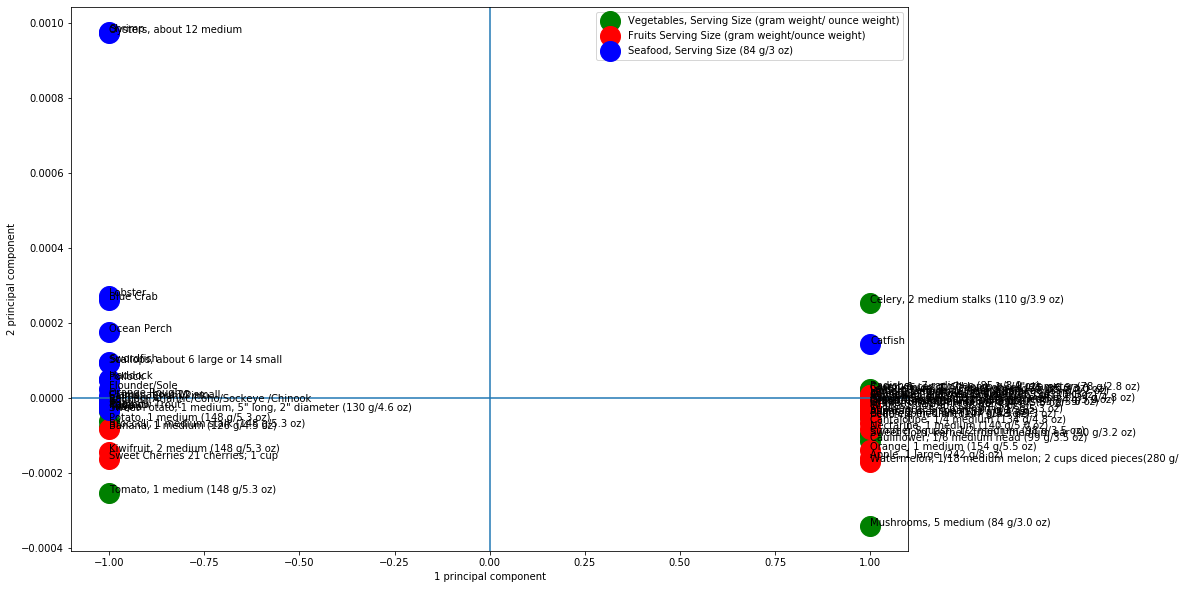

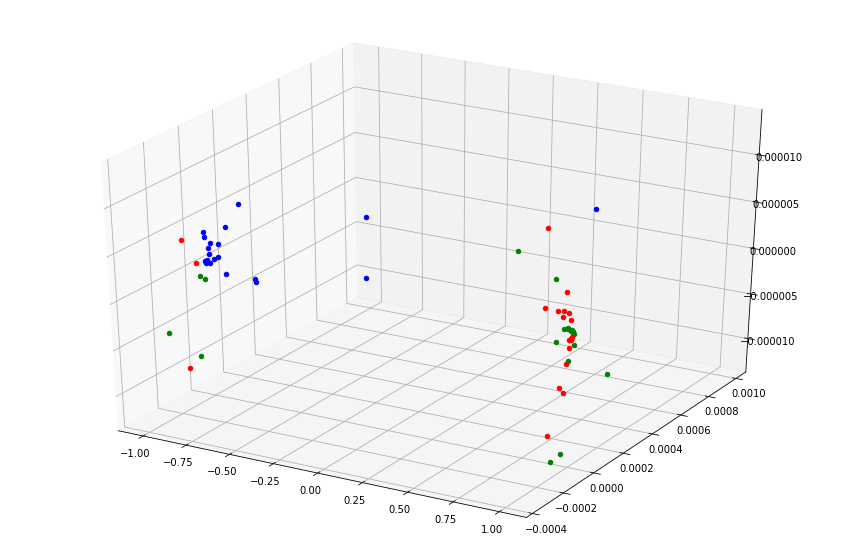

In [134]:
def norm_vectors(A):
    An = A.copy()
    # TODO: write here a code that will norm each vector, 
    #i.e. will divide each row of A by its norm ||A[i]||
    for i in range(An.shape[0]):
        An[[i],:] = An[[i],:]/np.linalg.norm(An[[i],:])
    return An
    
An = norm_vectors(Ak)

print("2 first dimensions")
show_points_2d(An.T[0], An.T[1], "1 principal component", "2 principal component")
show_points_3d(An.T[0].A1, An.T[1].A1, An.T[2].A1)

## Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend closes food items in terms of nutrition. Please, write this code, that will return $k$ closest food items to the provided query vector.

In [13]:
def find_k_closest(query, dataset, k=5):
    # TODO: write here the code, that will find 5 closest rows in dataset in terms of cosine similarity
    # HINT: as the vectors in dataset are already normed, cosine similarity is just dot product.
    
    return []


recommend_to = 0
r = find_k_closest(An[recommend_to,:], An)

print("For:", names[recommend_to])
for k, v, p in r:
    print("\t", names[k], "sim=", p)

For: Asparagus, 5 spears (93 g/3.3 oz)
	 Onion, 1 medium (148 g/5.3 oz) sim= 0.969961541150283
	 Plums, 2 medium (151 g/5.4 oz) sim= 0.973985624217893
	 Green (Snap) Beans, 3/4 cup cut (83 g/3.0 oz) sim= 0.9825536879398231
	 Peach, 1 medium (147 g/5.3 oz) sim= 0.9913402943604573
	 Asparagus, 5 spears (93 g/3.3 oz) sim= 0.9999999999999999


## Bonus level
Please estimate code you wrote in previous block with RAM model. What do you think, will this work for a bigger dataset? Storing the data as-is will lead to slow requests processing. But what about building an index? Ball-tree looks like what you exactly need. Build a ball-tree for the normed dataset `An`.

In [14]:
# write your code here